Highest score: -136.29862814934262


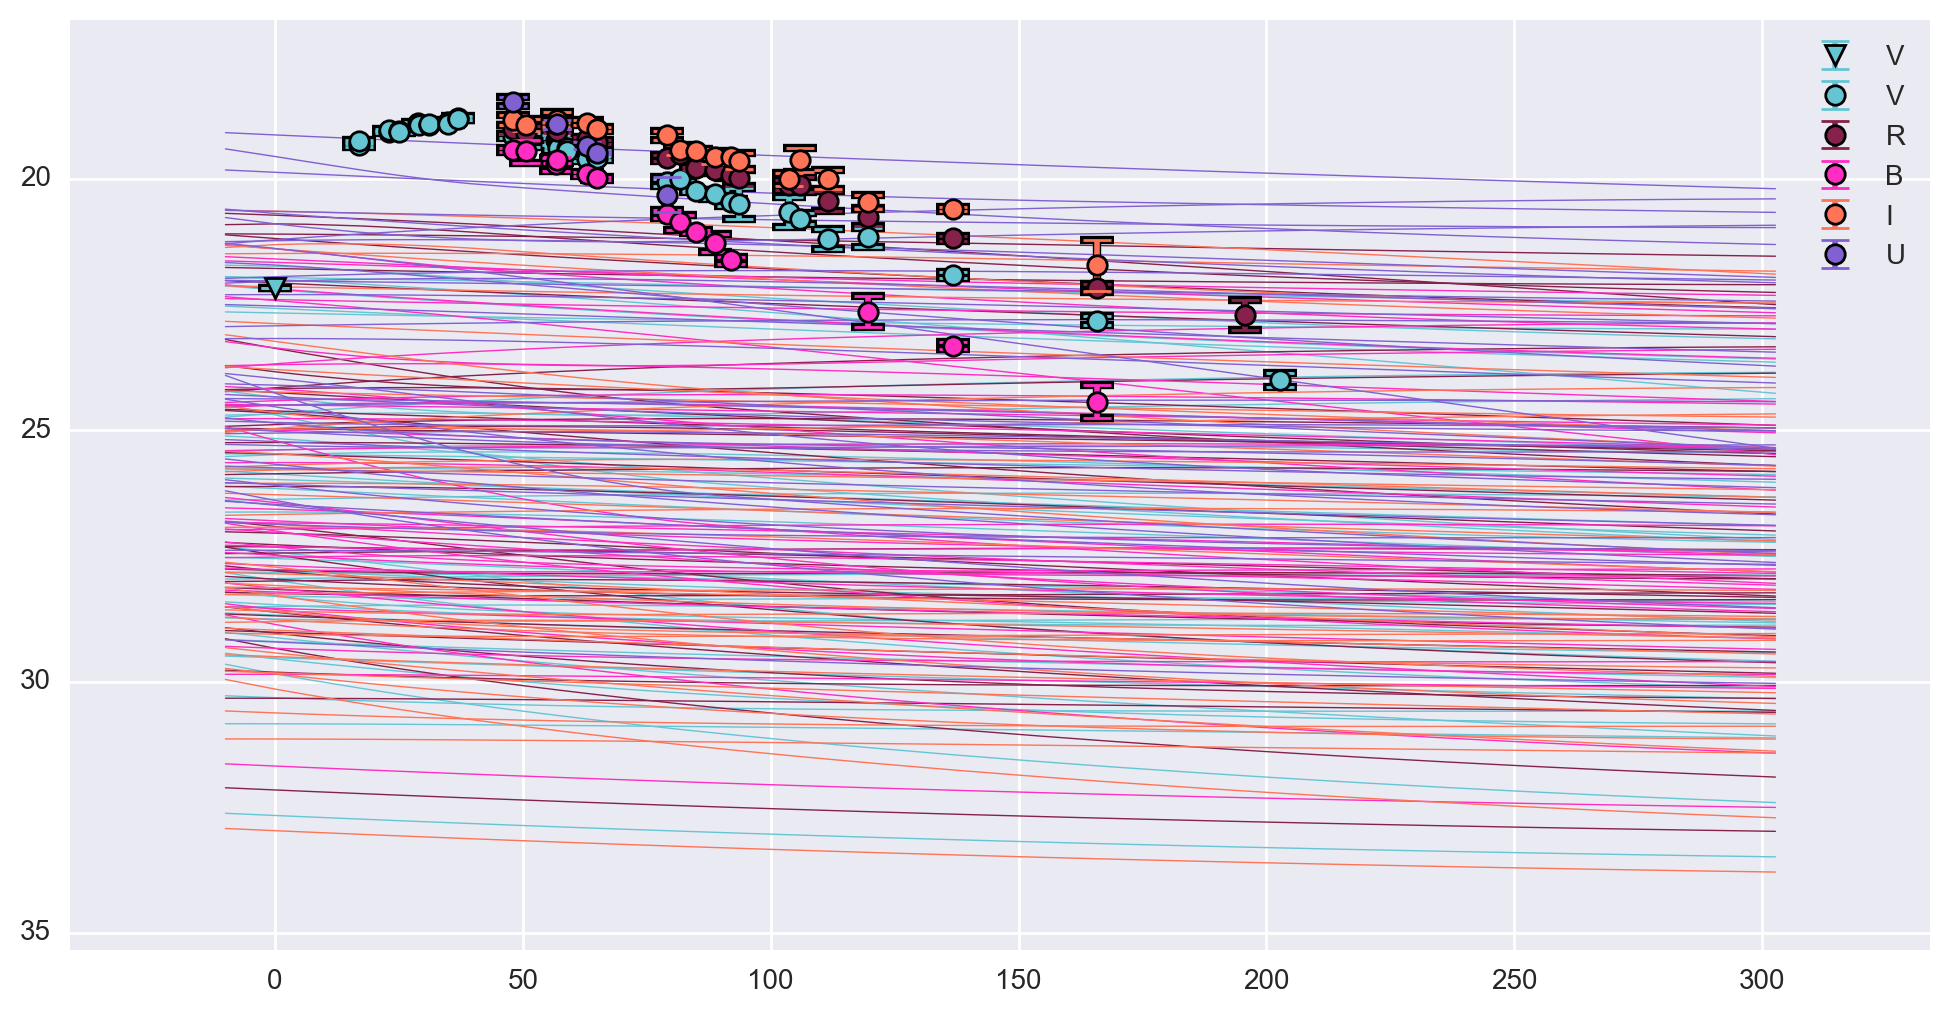

In [38]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import corner
import json
import matplotlib.pyplot as plt
import numpy as np
from mosfit.plotting import bandcolorf

with open('../products/walkers.json', 'r') as f:
    data = json.loads(f.read())
    
# Find best scoring walker
if 'score' in data['0']:
    real_data = True
    max_score = max([data[x]['score'] for x in data])
    print('Highest score: ' + str(max_score))
    for x in data:
        if data[x]['score'] == max_score:
            bdata = data[x]
            break
else:
    real_data = False
    bdata = data['0']
band_names = list(set(bdata['bands']))

fig = plt.figure(figsize=(12,6))
used_bands = []
for band in band_names:
    for walk in data:
        bdata = data[walk]
        xs, ys = zip(*[
            [x, y] for x, y, z in
            zip(bdata['times'], bdata['model_magnitudes'], bdata['bands'])
            if z == band])
        label = '' if real_data or band in used_bands else band
        plt.plot(xs, ys, c=bandcolorf(band), label=label, linewidth=0.5)
        used_bands = list(set(used_bands + [band]))
    if real_data:
        times = np.array([x for x, y in zip(bdata['times'], bdata['observed']) if y])
        mags = np.array(bdata['magnitudes'])
        e_mags = np.array([x if x != '' else 0.0 for x in bdata['e_magnitudes']])
        bands = np.array([x for x, y in zip(bdata['bands'], bdata['observed']) if y])
        upp_lims = np.array(bdata['upperlimits'])
        for s in range(2):
            if s == 0:
                cond = upp_lims != False
                symb = 'v'
            else:
                cond = upp_lims == False
                symb = 'o'
            ltimes = times[cond]
            lmags = mags[cond]
            le_mags = e_mags[cond]
            lbands = bands[cond]
            vec = [[x, y, ye] for x, y, ye, z in
                   zip(ltimes, lmags, le_mags, lbands)
                   if z == band]
            if not len(vec):
                continue
            xs, ys, yes = zip(*vec)
            plt.errorbar(xs, ys, yerr=yes, color=bandcolorf(band), fmt=symb,
                         label=(band if real_data or band not in used_bands else ''),
                         markeredgecolor='black', markeredgewidth=1, capsize=5,
                         elinewidth=2, capthick=2, zorder=10)
            plt.errorbar(xs, ys, yerr=yes, color='k', fmt=symb, capsize=6,
                         elinewidth=3, capthick=3, zorder=5)
plt.gca().invert_yaxis()
plt.margins(0.1,0.1)
plt.legend()
plt.show()
fig.savefig('../products/lc.pdf')

# Construct walker arrays for corner
print('Preparing corner plot, takes some time.')
corner_input = []
for w in data:
    pars = data[w]['parameters']
    var_names = ['$' + ('\\log\\, ' if pars[x]['log'] else '') +
                 pars[x]['latex'] + '$' for x in pars]
    corner_input.append([np.log10(pars[x]['value']) if
                         pars[x]['log'] else pars[x]['value'] for x in pars])
cfig = corner.corner(corner_input, labels=var_names)
cfig.savefig('../products/corner.pdf')